# fastai training

In [ ]:
from fastai.basic_train import *
from fastai.gen_doc.nbdoc import *

[<code>fastai.basic_train</code>](http://docs.fast.ai/basic_train.html#fastai.basic_train) wraps together the data (in a [<code>DataBunch</code>](http://docs.fast.ai/data.html#DataBunch) object) with a pytorch model to define a [<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner) object. This is where the basic training loop is defined for the [<code>fit</code>](http://docs.fast.ai/basic_train.html#fit) function. The [<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner) object is the entry point of most of the [<code>Callback</code>](http://docs.fast.ai/callback.html#Callback) functions that will customize this training loop in different ways (and made available through the [<code>fastai.train</code>](http://docs.fast.ai/train.html#fastai.train) module), notably:

 - `Learner.lr_find` will launch an LR range test that will help you select a good learning rate
 - `Learner.fit_one_cycle` will launch a training using the 1cycle policy, to help you train your model fast.
 - `Learner.to_fp16` will convert your model in half precision and halp you launch a training in mixed precision.

## Basic training overview

We'll do a quick overview of the key pieces of fastai's training modules. See the separate module docs (linked below) for details on each. We'll use the classic MNIST dataset for the training documentation, cut down to just 3's and 7's. The data is available in the fastai repo in the `docs/` directory.

To minimize the boilerplate in our docs we've defined the basic imports and paths we need in fastai.docs. It also has a [<code>get_mnist</code>](http://docs.fast.ai/docs.html#get_mnist) function to grab a [<code>DataBunch</code>](http://docs.fast.ai/data.html#DataBunch) of the data for us.

In [ ]:
from fastai.docs import *
data = get_mnist()

### Basic training with [<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner)

We can create minimal simple CNNs using [<code>simple_cnn</code>](http://docs.fast.ai/layers.html#simple_cnn) (see `models` for details on creating models):

In [ ]:
model = simple_cnn((3,16,16,2))

The most important object for training models is [<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner), which needs to know, at minimum, what data to train with and what model to train.

In [ ]:
learn = Learner(data, model)

That's enough to train a model, which is done using [<code>fit</code>](http://docs.fast.ai/basic_train.html#fit). If you have a CUDA-capable GPU it will be used automatically. You have to say how many epochs to train for.

In [ ]:
learn.fit(1)

Total time: 00:01
epoch  train loss  valid loss
0      0.150462    0.122648    (00:01)



### Viewing metrics

To see how our training is going, we can request that it reports various [<code>fastai.metrics</code>](http://docs.fast.ai/metrics.html#fastai.metrics) after each epoch. You can pass it to the constructor, or set it later. Note that metrics are always calculated on the validation set.

In [ ]:
learn.metrics=[accuracy]
learn.fit(1)

Total time: 00:01
epoch  train loss  valid loss  accuracy
0      0.088807    0.074429    0.973994  (00:01)



### Extending training with callbacks

You can use [<code>fastai.callback</code>](http://docs.fast.ai/callback.html#fastai.callback)s to modify training in almost any way you can imagine. For instance, we've provided a callback to implement Leslie Smith's 1cycle training method.

In [ ]:
cb = OneCycleScheduler(learn, lr_max=0.01)
learn.fit(1, callbacks=cb)

Total time: 00:01
epoch  train loss  valid loss  accuracy
0      0.058238    0.045113    0.983808  (00:01)



The [<code>Recorder</code>](http://docs.fast.ai/basic_train.html#Recorder) callback is automatically added for you, and you can use it to see what happened in your training, e.g.:

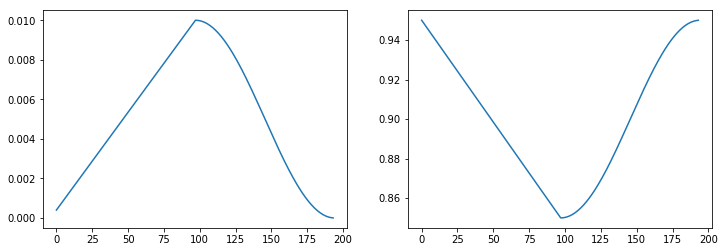

In [ ]:
learn.recorder.plot_lr(show_moms=True)

### Applications

Note that if you're training a model for one of our supported *applications*, there's a lot of help available to you in the application modules:

- [<code>fastai.vision</code>](http://docs.fast.ai/vision.html#fastai.vision)
- `text`
- `tabular`
- `colab`


In [ ]:
show_doc(Learner, title_level=2)

## <a id=Learner></a><em>class</em> `Learner`
(<code>data</code>:[<code>DataBunch</code>](http://docs.fast.ai/data.html#DataBunch), <code>model</code>:[<code>Module</code>](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), <code>opt_fn</code>:<code>Callable</code>=`functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))`, <code>loss_fn</code>:<code>Callable</code>=`<function cross_entropy at 0x7f9ef8dda488>`, <code>metrics</code>:<code>Collection</code>[<code>Callable</code>]=`None`, <code>true_wd</code>:<code>bool</code>=`True`, <code>bn_wd</code>:<code>bool</code>=`True`, <code>wd</code>:<code>Union</code>[<code>float</code>, <code>Collection</code>[<code>float</code>]]=`0.01`, <code>train_bn</code>:<code>bool</code>=`True`, <code>path</code>:<code>str</code>=`None`, <code>model_dir</code>:<code>str</code>=`'models'`, <code>callback_fns</code>:<code>Collection</code>[<code>Callable</code>]=`None`, <code>callbacks</code>:<code>Collection</code>[[<code>Callback</code>](http://docs.fast.ai/callback.html#Callback)]=`<factory>`, <code>layer_groups</code>:<code>Collection</code>[[<code>Module</code>](https://pytorch.org/docs/stable/nn.html#torch.nn.Module)]=`None`) -> <code>None</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L90">[source]</a></div>


Object that wraps together some data, a model, a loss function and an optimizer

The main purpose of [<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner) is to train `model` using `Learner.fit`. After every epoch, all [<code>fastai.metrics</code>](http://docs.fast.ai/metrics.html#fastai.metrics) will be printed, and will also be available to callbacks.

The default weight decay will be `wd`, which will be handled using the method from [Fixing Weight Decay Regularization in Adam](https://arxiv.org/abs/1711.05101) if `true_wd` is set (otherwise it's L2 regularization). If `bn_wd` is False then weight decay will be removed from batchnorm layers, as recommended in [Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour](https://arxiv.org/abs/1706.02677). You can also turn off batchnorm layer training entirely (i.e. freeze all batchnorm learnable parameters) by disabling `train_bn`.

To use [discriminative layer training](#discriminative) pass an `nn.Module` for each layer group to be optimized with different settings.

Any model files created will be saved in `path`/`model_dir`.

You can pass a list of [<code>fastai.callbacks</code>](http://docs.fast.ai/callbacks.html#fastai.callbacks) that you have already created, or (more commonly) simply pass a list of callback functions to `callback_fns` and each function will be called (passing `self`) on object initialization, with the results stored as callback objects.

### Model fitting methods

In [ ]:
show_doc(Learner.fit)

#### <a id=fit></a>`fit`
(<code>epochs</code>:<code>int</code>, <code>lr</code>:<code>Union</code>[<code>float</code>, <code>Collection</code>[<code>float</code>], <code>slice</code>]=`slice(None, 0.003, None)`, <code>wd</code>:<code>Union</code>[<code>float</code>, <code>Collection</code>[<code>float</code>]]=`None`, <code>callbacks</code>:<code>Collection</code>[[<code>Callback</code>](http://docs.fast.ai/callback.html#Callback)]=`None`) -> <code>None</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L125">[source]</a></div>


fit the model on this learner with `lr` learning rate, `wd` weight decay for `epochs` with `callbacks`

Uses [discriminative layer training](#discriminative) if multiple learning rates or weight decay values are passed. To control training behaviour, use the [<code>fastai.callback</code>](http://docs.fast.ai/callback.html#fastai.callback) system or one or more of the pre-defined [<code>fastai.callbacks</code>](http://docs.fast.ai/callbacks.html#fastai.callbacks).

In [ ]:
show_doc(Learner.fit_one_cycle)

#### <a id=fit_one_cycle></a>`fit_one_cycle`
(<code>learn</code>:[<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner), <code>cyc_len</code>:<code>int</code>, <code>max_lr</code>:<code>Union</code>[<code>float</code>, <code>Collection</code>[<code>float</code>], <code>slice</code>]=`slice(None, 0.003, None)`, <code>moms</code>:<code>Tuple</code>[<code>float</code>, <code>float</code>]=`(0.95, 0.85)`, <code>div_factor</code>:<code>float</code>=`25.0`, <code>pct_start</code>:<code>float</code>=`0.3`, <code>wd</code>:<code>float</code>=`None`, <code>kwargs</code>) -> <code>None</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/train.py#L11">[source]</a></div>


Fits a model following the 1cycle policy

Uses the [<code>OneCycleScheduler</code>](http://docs.fast.ai/callbacks.one_cycle.html#OneCycleScheduler) callback.

In [ ]:
show_doc(Learner.lr_find)

#### <a id=lr_find></a>`lr_find`
(<code>learn</code>:[<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner), <code>start_lr</code>:<code>float</code>=`1e-05`, <code>end_lr</code>:<code>float</code>=`10`, <code>num_it</code>:<code>int</code>=`100`, <code>kwargs</code>:<code>Any</code>)
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/train.py#L20">[source]</a></div>


Explore lr from `start_lr` to `end_lr` over `num_it` iterations of `learn`

Runs the learning rate finder defined in [<code>LRFinder</code>](http://docs.fast.ai/callbacks.lr_finder.html#LRFinder), as discussed in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186). 

### Mixed precision training

In [ ]:
show_doc(Learner.to_fp16)

#### <a id=to_fp16></a>`to_fp16`
(<code>learn</code>:[<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner), <code>loss_scale</code>:<code>float</code>=`512.0`, <code>flat_master</code>:<code>bool</code>=`False`) -> [<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner)
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/train.py#L26">[source]</a></div>


Transforms the learner in FP16 precision

Uses the [<code>MixedPrecision</code>](http://docs.fast.ai/callbacks.fp16.html#MixedPrecision) callback to train in mixed precision (i.e. forward and backward passes using fp16, with weight updates using fp32), using all [NVIDIA recommendations](https://docs.nvidia.com/deeplearning/sdk/mixed-precision-training/index.html) for ensuring speed and accuracy.

### Discriminative layer training

When fitting a model you can pass a list of learning rates (and/or weight decay amounts), which will apply a different rate to each *layer group* (i.e. the parameters of each module in `self.layer_groups`). See the [Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/abs/1801.06146) paper for details and experimental results in NLP (we also frequently use them successfully in computer vision, but have not published a paper on this topic yet).

In [ ]:
show_doc(Learner.unfreeze)

#### <a id=unfreeze></a>`unfreeze`()
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L156">[source]</a></div>


unfreeze entire model

Sets every layer group to *trainable* (i.e. `requires_grad=True`).

In [ ]:
show_doc(Learner.freeze)

#### <a id=freeze></a>`freeze`() -> <code>None</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L151">[source]</a></div>


freeze up to last layer

Sets every layer group except the last to *untrainable* (i.e. `requires_grad=False`).

In [ ]:
show_doc(Learner.freeze_to)

#### <a id=freeze_to></a>`freeze_to`(<code>n</code>:<code>int</code>) -> <code>None</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L144">[source]</a></div>


freeze layers up to layer `n`

In [ ]:
show_doc(Learner.split)

#### <a id=split></a>`split`
(<code>split_on</code>:<code>Union</code>[<code>Callable</code>, <code>Collection</code>[<code>Collection</code>[[<code>Module</code>](https://pytorch.org/docs/stable/nn.html#torch.nn.Module)]]]) -> <code>None</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L139">[source]</a></div>


split the model at `split_on`

A convenience method that sets `layer_groups` based on the result of calling a function you provide, or alternatively by collating a list of lists of modules.

In [ ]:
show_doc(Learner.lr_range)

#### <a id=lr_range></a>`lr_range`(<code>lr</code>:<code>Union</code>[<code>float</code>, <code>slice</code>]) -> <code>ndarray</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L118">[source]</a></div>


Build learning rate schedule

A convenience method that returns one learning rate for each layer group. If you pass `slice(start,end)` then the first group's learning rate is `start`, the last is `end`, and the remaining are evenly geometrically spaced.

If you pass just `slice(end)` then the last group's learning rate is `end`, and all the other groups are `end/3`.

### Saving and loading models

Simply call `Learner.save` and `Learner.load` to save and load models. Only the parameters are saved, not the actual architecture (so you'll need to create your model in the same way before loading weights back in). Models are saved to the `path`/`model_dir` directory.

In [ ]:
show_doc(Learner.load)

#### <a id=load></a>`load`(<code>name</code>:<code>Union</code>[<code>Path</code>, <code>str</code>])
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L166">[source]</a></div>


load model `name` from `self.model_dir

In [ ]:
show_doc(Learner.save)

#### <a id=save></a>`save`(<code>name</code>:<code>Union</code>[<code>Path</code>, <code>str</code>])
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L162">[source]</a></div>


save model with `name` to `self.model_dir`

### Other methods

In [ ]:
show_doc(Learner.init)

#### <a id=init></a>`init`(<code>init</code>)
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L116">[source]</a></div>

Initializes all weights (except batchnorm) using function `init`, which will often be from PyTorch's `nn.init` module.

In [ ]:
show_doc(Learner.mixup)

#### <a id=mixup></a>`mixup`
(<code>learn</code>:[<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner), <code>alpha</code>:<code>float</code>=`0.4`, <code>stack_x</code>:<code>bool</code>=`False`, <code>stack_y</code>:<code>bool</code>=`True`) -> [<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner)
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/train.py#L33">[source]</a></div>


Adds mixup https://arxiv.org/abs/1710.09412 to the learner

Adds [<code>MixUpCallback</code>](http://docs.fast.ai/callbacks.mixup.html#MixUpCallback) to the callbacks.

In [ ]:
show_doc(Learner.pred_batch)

#### <a id=pred_batch></a>`pred_batch`
(<code>learn</code>:[<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner), <code>is_valid</code>:<code>bool</code>=`True`) -> <code>Tuple</code>[<code>Union</code>[<code>Tensor</code>, <code>Collection</code>[<code>Tensors</code>]], <code>Union</code>[<code>Tensor</code>, <code>Collection</code>[<code>Tensors</code>]], <code>Union</code>[<code>Tensor</code>, <code>Collection</code>[<code>Tensors</code>]]]
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/tta.py#L8">[source]</a></div>


Returns input, target and output of the model on a batch

Get the first batch of predictions. Mainly useful for debugging and quick tests.

In [ ]:
show_doc(Learner.create_opt)

#### <a id=create_opt></a>`create_opt`
(<code>lr</code>:<code>Union</code>[<code>float</code>, <code>Collection</code>[<code>float</code>]], <code>wd</code>:<code>Union</code>[<code>float</code>, <code>Collection</code>[<code>float</code>]]=`0.0`) -> <code>None</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L135">[source]</a></div>


create optimizer with `lr` learning rate and `wd` weight decay

You generally won't need to call this yourself - it's used to create the `nn.optim` optimizer before fitting the model.

In [ ]:
show_doc(Recorder, title_level=2)

## <a id=Recorder></a><em>class</em> `Recorder`(<code>learn</code>:[<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner)) :: [<code>LearnerCallback</code>](http://docs.fast.ai/basic_train.html#LearnerCallback)
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L180">[source]</a></div>


A [<code>LearnerCallback</code>](http://docs.fast.ai/basic_train.html#LearnerCallback) that records epoch,loss,opt and metric data during training

A [<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner) creates a [<code>Recorder</code>](http://docs.fast.ai/basic_train.html#Recorder) object automatically - you do not need to explicitly pass to `callback_fns` - because other callbacks rely on it being available. It stores the smoothed loss, hyperparameter values, and metrics each batch, and provides plotting methods for each.

### Plotting methods

In [ ]:
show_doc(Recorder.plot)

#### <a id=plot></a>`plot`(<code>skip_start</code>:<code>int</code>=`10`, <code>skip_end</code>:<code>int</code>=`5`) -> <code>None</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L233">[source]</a></div>


Plot learning rate and losses, trimmed between `skip_start` and `skip_end`

In [ ]:
show_doc(Recorder.plot_losses)

#### <a id=plot_losses></a>`plot_losses`() -> <code>None</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L241">[source]</a></div>


Plot training and validation losses

In [ ]:
show_doc(Recorder.plot_lr)

#### <a id=plot_lr></a>`plot_lr`(<code>show_moms</code>=`False`) -> <code>None</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L224">[source]</a></div>


Plot learning rate, `show_moms` to include momentum

In [ ]:
show_doc(Recorder.plot_metrics)

#### <a id=plot_metrics></a>`plot_metrics`() -> <code>None</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L250">[source]</a></div>


Plot metrics collected during training

### Callback methods

You don't call these yourself - they're called by fastai's [<code>fastai.callback</code>](http://docs.fast.ai/callback.html#fastai.callback) system automatically to enable the class's functionality.

In [ ]:
show_doc(Recorder.on_backward_begin)

#### <a id=on_backward_begin></a>`on_backward_begin`(<code>smooth_loss</code>:<code>Tensor</code>, <code>kwargs</code>:<code>Any</code>) -> <code>None</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L199">[source]</a></div>


Record the loss before any other callback has a chance to modify it.

In [ ]:
show_doc(Recorder.on_batch_begin)

#### <a id=on_batch_begin></a>`on_batch_begin`(<code>kwargs</code>:<code>Any</code>) -> <code>None</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L194">[source]</a></div>


Record learning rate and momentum at beginning of batch

In [ ]:
show_doc(Recorder.on_epoch_end)

#### <a id=on_epoch_end></a>`on_epoch_end`
(<code>epoch</code>:<code>int</code>, <code>num_batch</code>:<code>int</code>, <code>smooth_loss</code>:<code>Tensor</code>, <code>last_metrics</code>=`typing.Collection[typing.Union[torch.Tensor, numbers.Number]]`, <code>kwargs</code>:<code>Any</code>) -> <code>bool</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L205">[source]</a></div>


Save epoch info: num_batch, smooth_loss, metrics

In [ ]:
show_doc(Recorder.on_train_begin)

#### <a id=on_train_begin></a>`on_train_begin`
(<code>pbar</code>:<code>Union</code>[<code>MasterBar</code>, <code>ProgressBar</code>], <code>metrics</code>:<code>Collection</code>[<code>Callable</code>[<code>Tensor</code>, <code>Tensor</code>, <code>Union</code>[<code>Tensor</code>, <code>Number</code>]]], <code>kwargs</code>:<code>Any</code>) -> <code>None</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L187">[source]</a></div>


Initialize recording status at beginning of training

## Module functions

Generally you'll want to use a [<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner) to train your model, since they provide a lot of functionality and make things easier. However, for ultimate flexibility, you can call the same underlying functions that [<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner) calls behind the scenes.

In [ ]:
show_doc(fit)

#### <a id=fit></a>`fit`
(<code>epochs</code>:<code>int</code>, <code>model</code>:[<code>Module</code>](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), <code>loss_fn</code>:<code>Callable</code>[<code>Tensor</code>, <code>Tensor</code>, <code>OneEltTensor</code>], <code>opt</code>:[<code>Optimizer</code>](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer), <code>data</code>:[<code>DataBunch</code>](http://docs.fast.ai/data.html#DataBunch), <code>callbacks</code>:`Optional`[<code>Collection</code>[[<code>Callback</code>](http://docs.fast.ai/callback.html#Callback)]]=`None`, <code>metrics</code>:`Optional`[<code>Collection</code>[<code>Union</code>[<code>Tensor</code>, <code>Number</code>]]]=`None`) -> <code>None</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L57">[source]</a></div>


Fit the `model` on `data` and learn using `loss` and `opt`

Note that you have to create the `Optimizer` yourself if you call this function, whereas `Learn.fit` creates it for you automatically.

In [ ]:
show_doc(train_epoch)

#### <a id=train_epoch></a>`train_epoch`
(<code>model</code>:[<code>Module</code>](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), <code>dl</code>:[<code>DataLoader</code>](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), <code>opt</code>:[<code>Optimizer</code>](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer), <code>loss_func</code>:<code>Callable</code>[<code>Tensor</code>, <code>Tensor</code>, <code>OneEltTensor</code>]) -> <code>None</code>
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L48">[source]</a></div>


Simple training of `model` for 1 epoch of `dl` using optim `opt` and loss function `loss_func`

You won't generally need to call this yourself - it's what [<code>fit</code>](http://docs.fast.ai/basic_train.html#fit) calls for each epoch.

In [ ]:
show_doc(validate)

#### <a id=validate></a>`validate`
(<code>model</code>:[<code>Module</code>](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), <code>dl</code>:[<code>DataLoader</code>](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), <code>loss_fn</code>:`Optional`[<code>Callable</code>[<code>Tensor</code>, <code>Tensor</code>, <code>OneEltTensor</code>]]=`None`, <code>metrics</code>:`Optional`[<code>Collection</code>[<code>Union</code>[<code>Tensor</code>, <code>Number</code>]]]=`None`, <code>cb_handler</code>:`Optional`[[<code>CallbackHandler</code>](http://docs.fast.ai/callback.html#CallbackHandler)]=`None`, <code>pbar</code>:<code>Union</code>[<code>MasterBar</code>, <code>ProgressBar</code>, <code>NoneType</code>]=`None`) -> <code>Iterator</code>[<code>Tuple</code>[<code>Union</code>[<code>Tensor</code>, <code>int</code>], <code>Ellipsis</code>]]
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L39">[source]</a></div>


Calculate loss and metrics for the validation set

This is what [<code>fit</code>](http://docs.fast.ai/basic_train.html#fit) calls after each epoch. You can call it if you want to run inference on a [<code>DataLoader</code>](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) manually.

In [ ]:
show_doc(loss_batch)

#### <a id=loss_batch></a>`loss_batch`
(<code>model</code>:[<code>Module</code>](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), <code>xb</code>:<code>Tensor</code>, <code>yb</code>:<code>Tensor</code>, <code>loss_fn</code>:`Optional`[<code>Callable</code>[<code>Tensor</code>, <code>Tensor</code>, <code>OneEltTensor</code>]]=`None`, <code>opt</code>:`Optional`[[<code>Optimizer</code>](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer)]=`None`, <code>cb_handler</code>:`Optional`[[<code>CallbackHandler</code>](http://docs.fast.ai/callback.html#CallbackHandler)]=`None`, <code>metrics</code>:`Optional`[<code>Collection</code>[<code>Union</code>[<code>Tensor</code>, <code>Number</code>]]]=`None`) -> <code>Tuple</code>[<code>Union</code>[<code>Tensor</code>, <code>int</code>, <code>float</code>, <code>str</code>]]
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L15">[source]</a></div>


Calculate loss for a batch, calculate metrics, call out to callbacks as necessary

You won't generally need to call this yourself - it's what [<code>fit</code>](http://docs.fast.ai/basic_train.html#fit) and [<code>validate</code>](http://docs.fast.ai/basic_train.html#validate) call for each batch. It only does a backward pass if you set `opt`.

## Other classes

In [ ]:
show_doc(LearnerCallback)

### <a id=LearnerCallback></a><em>class</em> `LearnerCallback`(<code>learn</code>:[<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner)) -> <code>None</code> :: [<code>Callback</code>](http://docs.fast.ai/callback.html#Callback)
<div style="text-align: right"><a href="https://github.com/fastai/fastai_pytorch/blob/master/fastai/basic_train.py#L171">[source]</a></div>


Base class for creating callbacks for the [<code>Learner</code>](http://docs.fast.ai/basic_train.html#Learner)